## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

Загрузим данные.

In [1]:
import pandas as pd
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data = data.resample('1H').sum()

In [2]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


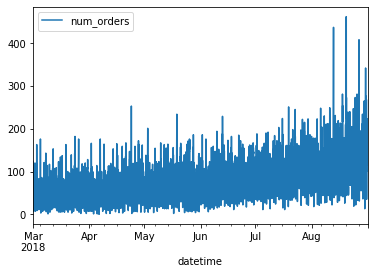

In [4]:
data.plot()

Проверим монотонность данных.

In [5]:
data.index.is_monotonic

True

# 2. Анализ

Посмотрим на тренды и сезонность данных.

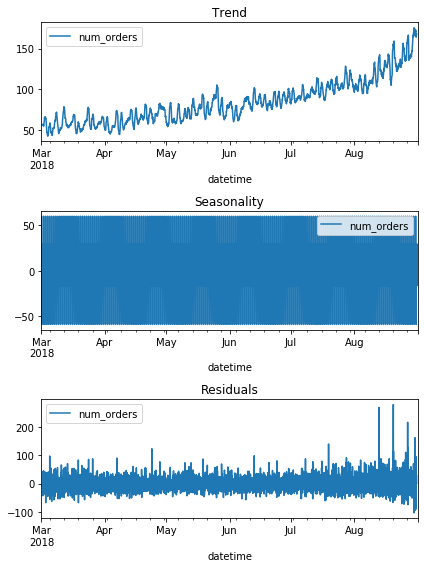

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

decomposed = seasonal_decompose(data)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()


В данных наблюдается общий растущий тренд.

# 3. Обучение

Создадим ополнительные признаки.

In [7]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

make_features(data, 24, 20)
data=data.dropna()

Подготовим выборки.

In [8]:
from sklearn.model_selection import train_test_split

train, v_t = train_test_split(data, shuffle = False, test_size = 0.2, random_state=12345)
valid, test = train_test_split(v_t, shuffle = False, test_size = 0.50, random_state=12345)

train_features = train.drop('num_orders', axis = 1)
train_target = train['num_orders']

valid_features = valid.drop('num_orders', axis = 1)
valid_target = valid['num_orders']

test_features = test.drop('num_orders', axis = 1)
test_target = test['num_orders']

Обучим модели линейной регрессии и случайного леса.

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model_lr = LinearRegression()
model_lr.fit(train_features,train_target)
pred_valid = model_lr.predict(valid_features)
print("RMSE валидационной выборки:", mean_squared_error(valid_target, pred_valid)**0.5)

RMSE валидационной выборки: 34.15199822048301


In [10]:
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor(n_estimators=200, random_state=12345)
model_rf.fit(train_features,train_target)
pred_valid = model_rf.predict(valid_features)
print("RMSE валидационной выборки:", mean_squared_error(valid_target, pred_valid)**0.5)

RMSE валидационной выборки: 33.097327669481835


С помощью кросс-валидации найдем лучшие гиперпараметры для модели с градиентным бустингом.

In [11]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

def rmse (target_valid, predicted_valid):
    mse = mean_squared_error(target_valid, predicted_valid)
    return mse**0.5

RMSE = make_scorer(rmse, greater_is_better = False)

model_lgb = lgb.LGBMRegressor()


parameters = {'num_leaves'         : [10,20,30],
              'learning_rate' : [0.03, 0.1, 0.5, 1], 
              'n_estimators'    : [100,200,400]}

grid = GridSearchCV(estimator=model_lgb, param_grid = parameters, cv = 2, n_jobs=-1, scoring=RMSE)
grid.fit(train_features,train_target)

print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)


 The best estimator across ALL searched params:
 LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.03, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=200, n_jobs=-1, num_leaves=30, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

 The best score across ALL searched params:
 -25.00176256851854

 The best parameters across ALL searched params:
 {'learning_rate': 0.03, 'n_estimators': 200, 'num_leaves': 30}


In [12]:
model_lgb = lgb.LGBMRegressor(learning_rate=0.03, n_estimators=200, n_jobs=-1, num_leaves=30)
model_lgb.fit(train_features,train_target)
pred_valid = model_lgb.predict(valid_features)
print("RMSE валидационной выборки:", mean_squared_error(valid_target, pred_valid)**0.5)

RMSE валидационной выборки: 33.02761495855207


Результаты на валидационной выборке получились достаточно близкими, проверим качество работы моделей на тестовой выборке.

# 4. Тестирование

Проверим качество работы моделей на тестовой выборке.

In [13]:
pred_test = model_lr.predict(test_features)
print("RMSE тестовой выборки:", mean_squared_error(test_target, pred_test)**0.5)

RMSE тестовой выборки: 46.172827783003974


In [14]:
pred_test = model_rf.predict(test_features)
print("RMSE тестовой выборки:", mean_squared_error(test_target, pred_test)**0.5)

RMSE тестовой выборки: 50.147536928547154


In [15]:
pred_test = model_lgb.predict(test_features)
print("RMSE тестовой выборки:", mean_squared_error(test_target, pred_test)**0.5)

RMSE тестовой выборки: 52.14674473993899


На тестовой выборке нам удалось достичь значения RMSE равного 46,17.